In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units

import sys
sys.path.append('../../') # lets us import ptype package from the subdir

from sounding_utils import *

#import ptype.

## Select forecast hour:

In [2]:
hour = '0000'

In [3]:
rap = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
rap.attrs['nwp'] = 'rap'
hrrr = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/hrrr/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
hrrr.attrs['nwp'] = 'hrrr'
gfs = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/gfs/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
gfs.attrs['nwp'] = 'gfs'


## plot where ML agrees and disagrees with NWP

In [19]:
def dis_agree(datasets: list[xr.Dataset], y_col: str, 
                              cols: list[str], 
                              colors: list[list[str]], 
                              markers: list[str],
                              prob: float = 0.0) -> None:
    '''function to output composite soundings with shaded quantile regions corresponding to 25/75
       and 10/90 quantiles. input list of predictions to plot and corresponding colors'''

    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,9))
    
    
    for i, ds in enumerate(datasets):

        y = ds[y_col].values
        marker = markers[i]
        
        ax = axs[0]

        for predtype,c in zip(cols, colors):
            if 'ML' in predtype:
                subset = ds.where(ds[predtype[3:]] == 1)
                subset = subset.where((ds[predtype] == 1))
            else:
                subset = ds.where(ds[predtype]==1)

            temperature_profile = subset['t_h'].mean(dim=('x','y','time'))
            line, = ax.plot(temperature_profile, y, c, linewidth=2, marker=marker, markersize=8)

            #label with num of observations
            num_obs = subset['t_h'].count(dim=('x','y','time')).values[0]

            line.set_label((
                f"{ds.attrs['nwp']}: "
                f"{predtype}{'>' + str(prob) if ('ML' in predtype) and (prob >0.0) else ''} |"
                f" Num Obs: {num_obs}"
            ))

        ax.set_title(f"ML predicts {cols[0][1:]} and agree with NWP")
        ax.set_xlabel('Temperature (C)')
        ax.set_ylabel('Height above ground (m)')
        ax.legend()
        
        ax = axs[1]
        for predtype,c in zip(cols, colors):
            if 'ML' in predtype:
                subset = ds.where(ds[predtype[3:]] != 1)
                subset = subset.where((ds[predtype] == 1))
            else:
                subset=ds.where(ds[f'ML_{predtype}'] != 1)
                subset = subset.where(ds[predtype]==1)

            temperature_profile = subset['t_h'].mean(dim=('x','y','time'))
            line, = ax.plot(temperature_profile, y, c, linewidth=2, marker=marker, markersize=8)

            #label with num of observations
            num_obs = subset['t_h'].count(dim=('x','y','time')).values[0]

            line.set_label((
                f"{ds.attrs['nwp']}: "
                f"{predtype}{'>' + str(prob) if ('ML' in predtype) and (prob >0.0) else ''} |"
                f" Num Obs: {num_obs}"
            ))

        ax.set_title(f"Models predict {cols[0][1:]} and disagree with the other")
        ax.set_xlabel('Temperature (C)')
        ax.set_ylabel('Height above ground (m)')
        ax.legend()

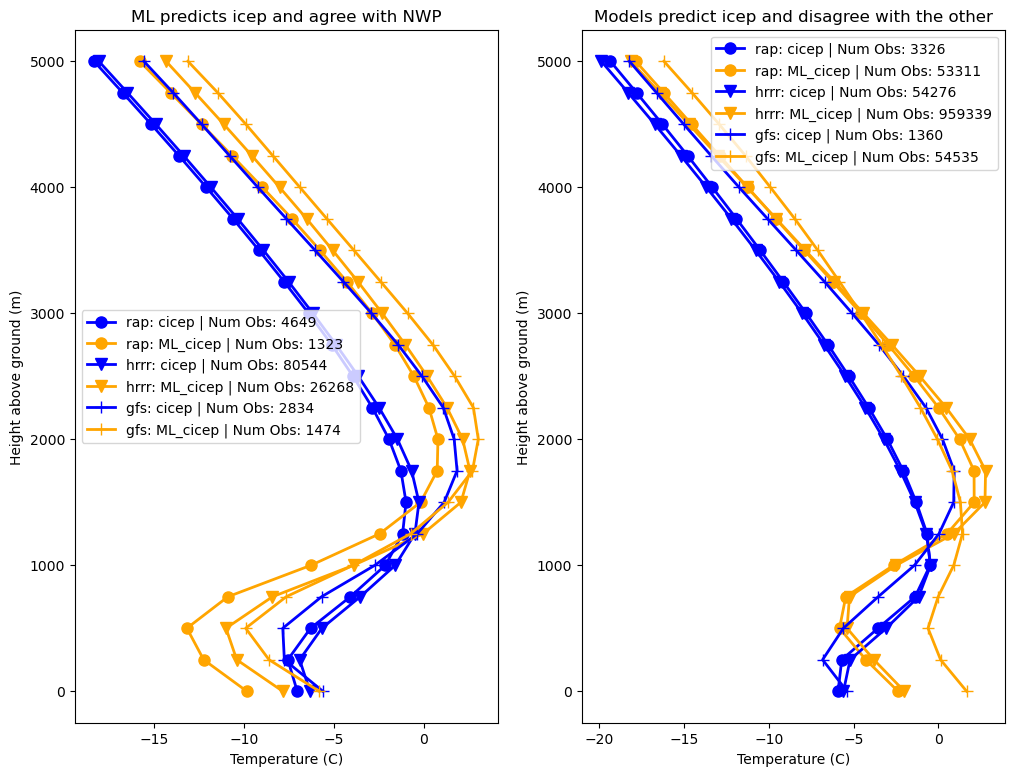

In [20]:
dis_agree([rap, hrrr, gfs], 'heightAboveGround', ['cicep', 'ML_cicep'], ['blue', 'orange'], ['o','v', '+'])


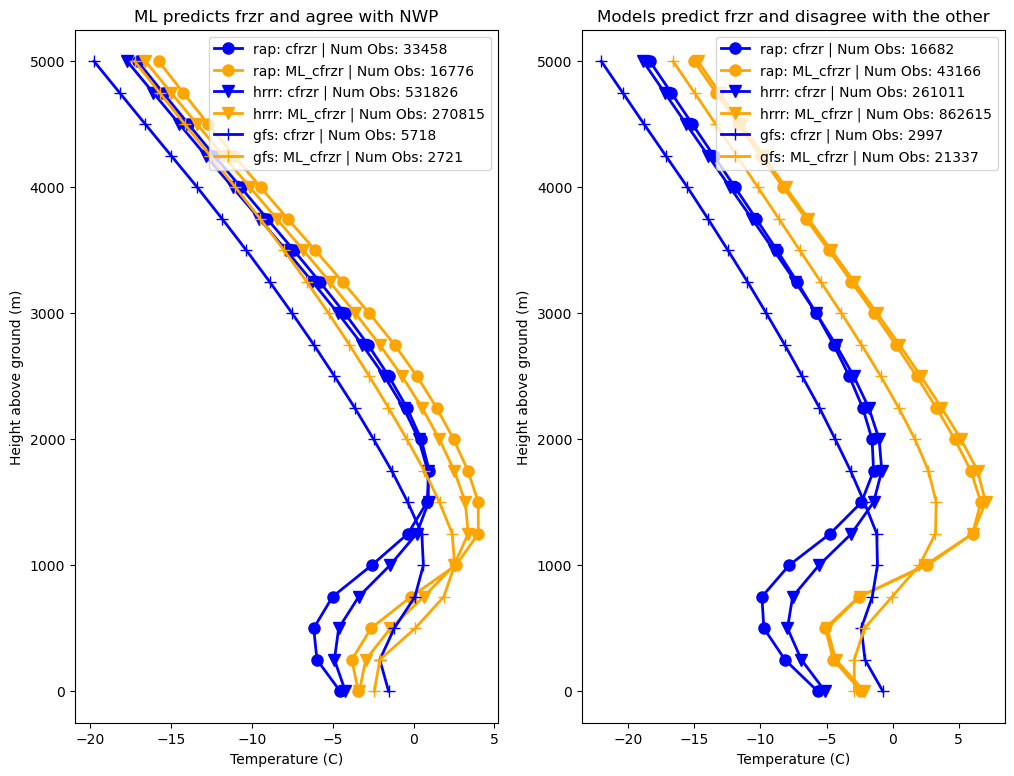

In [21]:
dis_agree([rap, hrrr, gfs], 'heightAboveGround', ['cfrzr', 'ML_cfrzr'], ['blue', 'orange'], ['o','v', '+'])


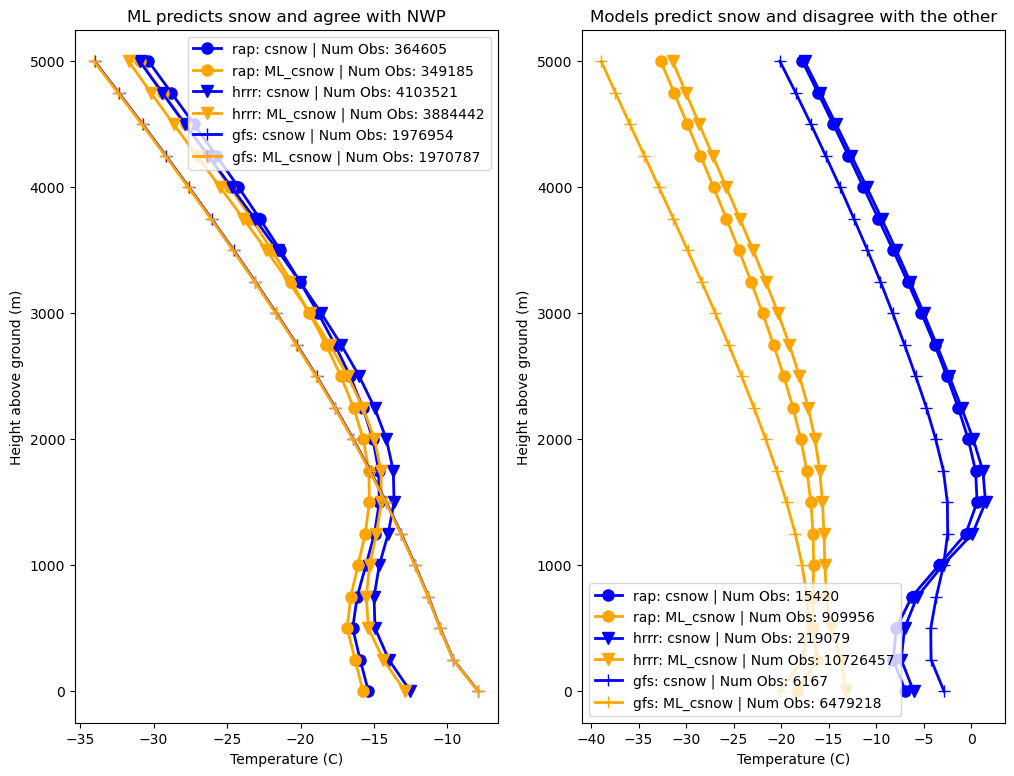

In [22]:
dis_agree([rap, hrrr, gfs], 'heightAboveGround', ['csnow', 'ML_csnow'], ['blue', 'orange'], ['o','v', '+'])

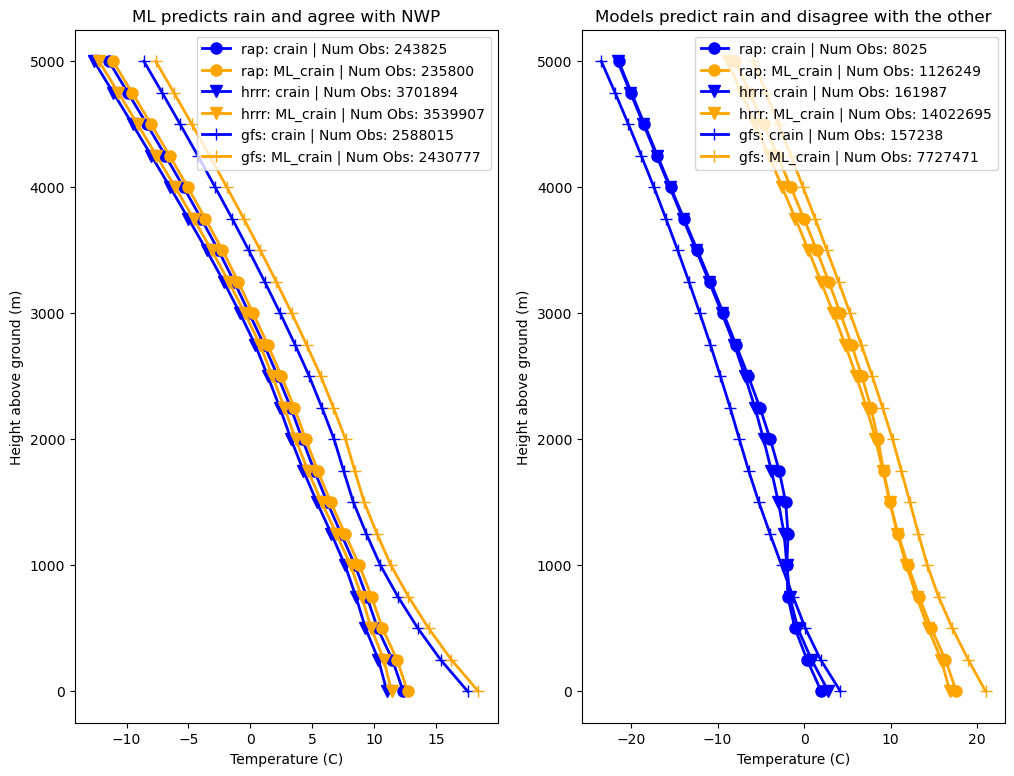

In [23]:
dis_agree([rap, hrrr, gfs], 'heightAboveGround', ['crain', 'ML_crain'], ['blue', 'orange'], ['o','v', '+'])